In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp


# Load the dataset
df_raw = pd.read_csv('ais_disabling_events.csv')

# Display the first few rows of the dataset
df_raw.head()

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours
0,40072d9edfca0cfd28872cbf9e382e0c,111112726,other,NaN,32.064056,139.583282,2018-03-22 08:59:22+00:00,11.847433,-21.832185,384000.0,2018-03-22 22:00:56+00:00,11.412485,-23.689107,384000.0,13.016667
1,52dcbd77bbdad9ee2642f574acf45190,150402949,other,CHN,54.994278,904.204044,2019-01-31 04:09:19+00:00,-45.895618,-60.642950,396000.0,2019-01-31 18:00:44+00:00,-45.808745,-60.654917,392000.0,13.850000
2,22b6d49ed4bb4d017884b6299ed185f4,204201370,other,PRT,15.350000,40.940000,2018-05-27 04:47:20+00:00,37.836315,-29.405573,95000.0,2018-05-28 14:32:01+00:00,37.860093,-29.286443,87000.0,33.733333
3,1abe463d7f61b110c44f1d1b4654a213,204206740,other,PRT,20.000000,77.263333,2019-06-21 12:17:01+00:00,32.190453,-18.031552,98000.0,2019-06-22 18:56:01+00:00,32.119552,-18.123323,109000.0,30.650000
4,72d047a15e33f67c3c5b91c78ff612be,204209840,other,PRT,20.000000,87.435000,2017-07-02 13:13:08+00:00,39.388467,-29.215400,93000.0,2017-07-04 15:30:29+00:00,38.909333,-28.329817,17000.0,50.283333


In [31]:
df_sampled = df_raw.sample(n=30000, random_state=42)

#  calculate distance traveled between start and end of gap. 
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    
    """
    Calculate the great circle distance in meters 
    between two points on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    # Radius of earth in kilometers is 6371
    meters = 6371 * c * 1000
    return meters

df_sampled['gap_distance'] = df_sampled.apply(lambda row: haversine(row['gap_start_lon'], row['gap_start_lat'], row['gap_end_lon'], row['gap_end_lat']), axis=1)

output_file_path = "ais_disabling_events_30k.csv"
df_sampled.to_csv(output_file_path, index=False)

In [32]:
# count unique 'flag' in df_sampled
df_sampled['flag'].value_counts()


# find empty or blank values in flag column
df_sampled['flag'].isnull().sum()

399

### Calculate distance to home country

In [33]:
ais_data = df_sampled.copy()

# Preprocess the data
# Drop rows where the 'flag' column is empty
ais_data = ais_data.dropna(subset=['flag'])

# Remove countries with 5 rows or less
country_counts = ais_data['flag'].value_counts()
countries_to_keep = country_counts[country_counts > 5].index
ais_data = ais_data[ais_data['flag'].isin(countries_to_keep)]
ais_data

,gap_id,mmsi,vessel_class,flag,vessel_length_m,vessel_tonnage_gt,gap_start_timestamp,gap_start_lat,gap_start_lon,gap_start_distance_from_shore_m,gap_end_timestamp,gap_end_lat,gap_end_lon,gap_end_distance_from_shore_m,gap_hours,gap_distance
20427,93f91a804ebd0df66d75effbe0d2fa6b,412329657,squid_jigger,CHN,70.870,1655.00,2019-11-24 03:34:35+00:00,41.887973,154.251947,555000.0,2019-11-25 09:16:41+00:00,41.360000,151.823333,487000.0,29.700000,2.102223e+05
35460,3131c481da6368d0b0848815727c8105,416004728,tuna_purse_seines,TWN,70.590,1288.00,2019-02-16 07:48:00+00:00,-1.455093,151.148613,126000.0,2019-02-17 05:38:59+00:00,-1.553607,151.193620,119000.0,21.833333,1.204251e+04
36795,7a486a9944cb3fd33bb048e4fe579e22,224253000,drifting_longlines,ESP,28.875,217.09,2019-07-12 07:32:00+00:00,42.041333,-46.535707,731000.0,2019-07-12 23:52:22+00:00,42.216347,-45.296107,791000.0,16.333333,1.040602e+05
7182,ad16e866a778de1b25e6e0a73141d00b,412329693,trawlers,CHN,58.790,1617.00,2019-01-28 07:50:30+00:00,-45.622633,-60.552412,392000.0,2019-02-01 23:28:31+00:00,-46.109898,-60.718597,397000.0,111.633333,5.568835e+04
12725,2a186f13a0c72c1cd2c2077bc43b4326,416505000,squid_jigger,TWN,69.735,929.00,2017-09-19 06:00:32+00:00,42.548682,152.617955,416000.0,2017-09-27 19:43:52+00:00,42.664412,153.422648,446000.0,205.716667,6.710265e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31043,a4cfec788cde8021d6f58e6c0ab6eb09,510086000,tuna_purse_seines,FSM,70.130,1350.00,2019-06-07 00:52:20+00:00,2.770080,153.287333,222000.0,2019-06-09 01:25:46+00:00,0.883048,153.296278,166000.0,48.550000,2.098307e+05
55249,d4a1673899500967685dd5914f775559,416000301,drifting_longlines,TWN,31.200,141.00,2019-08-23 06:12:27+00:00,-7.008538,-167.454397,463000.0,2019-09-03 08:49:41+00:00,-7.201565,-167.099188,430000.0,266.616667,4.468623e+04
32968,bbf4251124d4528fe3f5687ede81d958,663136000,tuna_purse_seines,SEN,77.550,2107.00,2018-05-25 11:56:28+00:00,3.963960,-3.404668,129000.0,2018-06-03 07:25:18+00:00,-0.051733,8.102080,92000.0,211.466667,1.354215e+06
23898,fedb9d9e2377f510547b8d96e4513b6b,412328785,squid_jigger,CHN,59.670,917.00,2019-07-10 11:16:53+00:00,-6.693592,-84.788427,410000.0,2019-07-12 23:43:36+00:00,-6.899878,-84.425407,376000.0,60.433333,4.618162e+04


In [34]:
# load geo shape files from shape_files folder
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [36]:
countries_border = gpd.read_file("shape_files_countries/ne_50m_admin_0_countries.shp")
# print(coastline.iloc[0:1, 3])
countries_border['geometry']


0      POLYGON ((31.28789 -22.40205, 31.19727 -22.344...
1      POLYGON ((30.39609 -15.64307, 30.25068 -15.643...
2      MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...
3      MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...
4      MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...
                             ...                        
237    POLYGON ((66.52227 37.34849, 66.82773 37.37129...
238    POLYGON ((77.04863 35.10991, 77.00449 35.19634...
239    MULTIPOLYGON (((-45.71777 -60.52090, -45.49971...
240    POLYGON ((-63.12305 18.06895, -63.01118 18.068...
241    POLYGON ((179.21367 -8.52422, 179.20059 -8.534...
Name: geometry, Length: 242, dtype: geometry

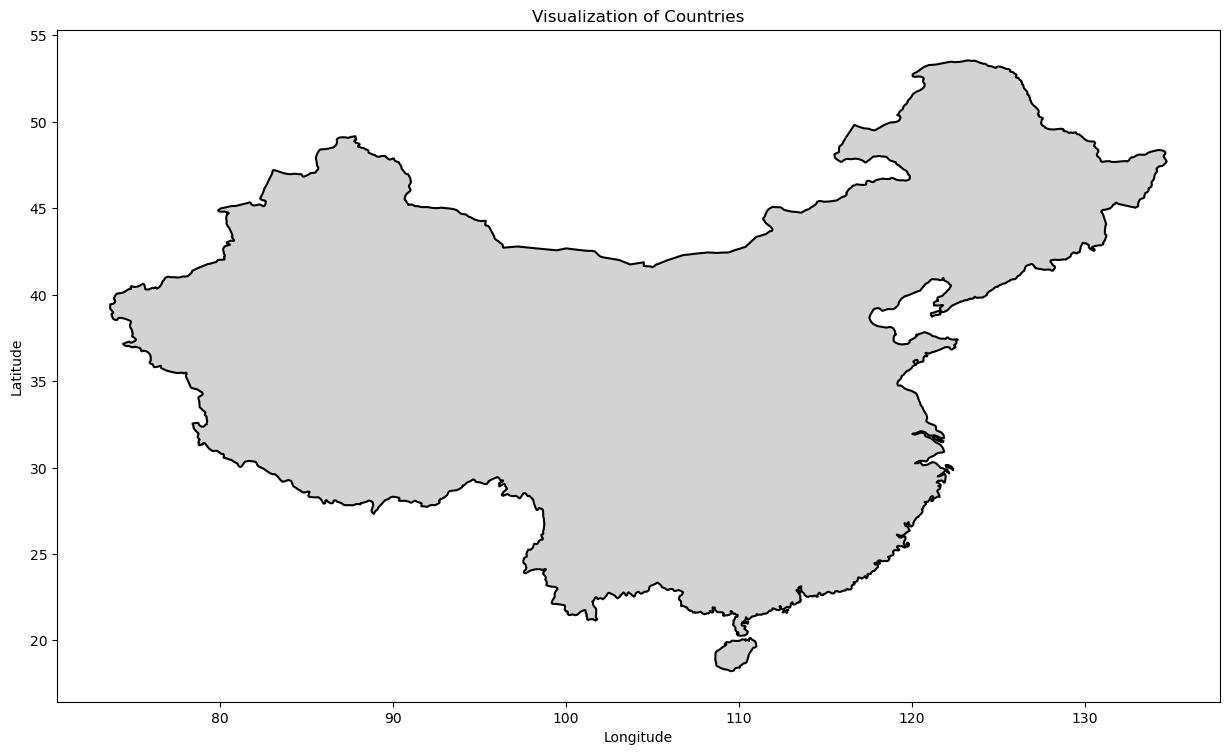

In [51]:
# filter the country borders GeoDataFrame to only include the specified countries
selected_countries = countries_border[countries_border['ADM0_A3'].isin(['CHN'])]

# Plot the selected countries
fig, ax = plt.subplots(figsize=(15, 15))
selected_countries.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# Set title and labels
ax.set_title("Visualization of Countries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [52]:
def num_points(geom):
    if geom.geom_type == 'Polygon':
        # Sum of exterior and all interior ring points
        return len(geom.exterior.coords) + sum(len(interior.coords) for interior in geom.interiors)
    elif geom.geom_type == 'MultiPolygon':
        # Recursively compute for each polygon and sum up
        return sum(num_points(polygon) for polygon in geom.geoms)
    else:
        return 0

selected_countries['num_points'] = selected_countries['geometry'].apply(num_points)
selected_countries[['SOVEREIGNT', 'num_points']]

c:\Users\Geran\anaconda3\envs\ais_fishing_signal\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,SOVEREIGNT,num_points
195,China,2662


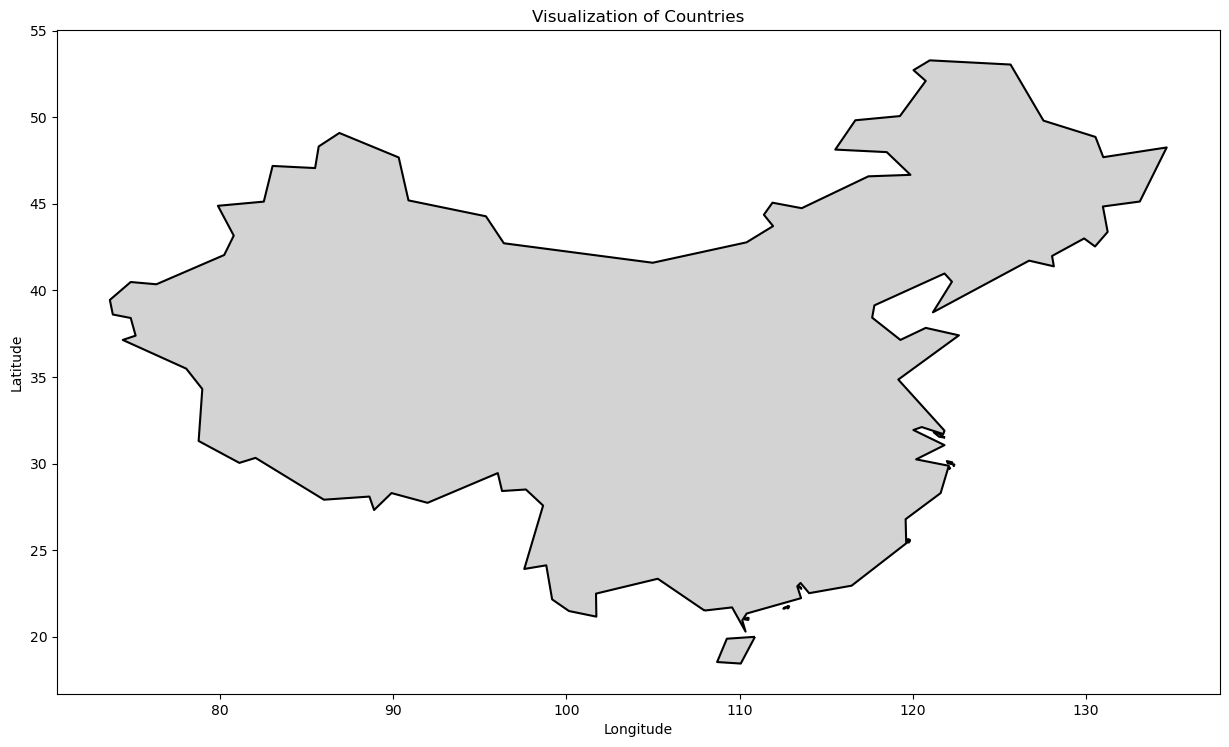

In [53]:
tolerance = 0.5
selected_countries_dpsimp = selected_countries.copy()
selected_countries_dpsimp['geometry'] = selected_countries_dpsimp['geometry'].simplify(tolerance, preserve_topology=True)

# Plot the selected countries
fig, ax = plt.subplots(figsize=(15, 15))
selected_countries_dpsimp.plot(ax=ax, edgecolor='black', color='lightgray', linewidth=1.5)

# Set title and labels
ax.set_title("Visualization of Countries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()


In [54]:
selected_countries_dpsimp['num_points'] = selected_countries_dpsimp['geometry'].apply(num_points)
selected_countries_dpsimp[['SOVEREIGNT', 'num_points']]

,SOVEREIGNT,num_points
195,China,158


In [ ]:
# Convert the AIS dataframe to a GeoDataFrame
geometry = [Point(xy) for xy in zip(ais_data.gap_start_lon, ais_data.gap_start_lat)]
ais_geo = GeoDataFrame(ais_data, geometry=geometry)

ais_geo.head()
